In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Instead of defining all layers at once, define them in a sequential container
        self.network = nn.Sequential(
            nn.Linear(784, 256),   # Changing the number of neurons in the first layer
            nn.LeakyReLU(),        # Replacing ReLU with LeakyReLU for a different activation behavior
            nn.Linear(256, 128),   # Adding an additional layer for more complexity
            nn.LeakyReLU(),
            nn.Linear(128, 10)     # Keeping the final layer to output 10 classes
        )

    def forward(self, x):
        x = x.view(-1, 784)       # Flatten the input as before
        x = self.network(x)       # Pass the input through the defined network
        return x


In [3]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    train_loss = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0  # Accumulate the loss for the entire epoch
        total_batches = len(train_loader)  # Total number of batches in the loader

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()               # Reset gradients
            outputs = model(inputs)             # Forward pass
            loss = criterion(outputs, labels)   # Compute loss
            loss.backward()                     # Backward pass
            optimizer.step()                    # Optimize the model

            epoch_loss += loss.item()           # Accumulate loss for this batch

        # Calculate and store the average loss per epoch
        avg_epoch_loss = epoch_loss / total_batches
        train_loss.append(avg_epoch_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}")

    return train_loss


In [4]:
def evaluate_model(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    cumulative_loss = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in data_loader:
            inputs, labels = batch
            outputs = model(inputs)  # Forward pass
            
            loss = criterion(outputs, labels)  # Calculate loss for the batch
            cumulative_loss += loss.item()  # Accumulate loss
            
            # Get predictions by selecting the class with the highest score
            predictions = outputs.argmax(dim=1)
            
            # Calculate correct predictions
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    
    # Compute accuracy
    accuracy = correct_predictions / total_samples
    
    # Return accuracy and average loss over all batches
    avg_loss = cumulative_loss / len(data_loader)
    
    return accuracy, avg_loss


In [5]:
def evaluate_model_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1)  # Simplified prediction logic
            all_labels.append(labels)
            all_predictions.append(predicted)

    # Concatenate all labels and predictions
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)

    # Calculate metrics using numpy directly on tensors
    precision = precision_score(all_labels.numpy(), all_predictions.numpy(), average='macro')
    recall = recall_score(all_labels.numpy(), all_predictions.numpy(), average='macro')
    f1 = f1_score(all_labels.numpy(), all_predictions.numpy(), average='macro')

    return precision, recall, f1

def linear_interpolation(model1, model2, alpha):
    """Perform linear interpolation between two models' state dictionaries."""
    new_model = SimpleNN()
    state_dict_model1 = model1.state_dict()
    state_dict_model2 = model2.state_dict()
    
    # Create a new state dictionary for the interpolated model
    interpolated_state_dict = {
        key: alpha * state_dict_model1[key] + (1 - alpha) * state_dict_model2[key]
        for key in state_dict_model1.keys()
    }

    # Load the interpolated state dictionary into the new model
    new_model.load_state_dict(interpolated_state_dict)
    return new_model

def interpolate_and_evaluate(model_m1, model_m2, alpha, train_loader, test_loader):
    """Perform interpolation between models and evaluate."""
    # Perform interpolation between model_m1 and model_m2
    interpolated_model = linear_interpolation(model_m1, model_m2, alpha)

    # Evaluate the interpolated model on training data
    accuracy_train, loss_train = evaluate_model(interpolated_model, train_loader)
    precision_train, recall_train, f1_train = evaluate_model_metrics(interpolated_model, train_loader)

    # Evaluate the interpolated model on test data
    accuracy_test, loss_test = evaluate_model(interpolated_model, test_loader)
    precision_test, recall_test, f1_test = evaluate_model_metrics(interpolated_model, test_loader)

    # Return training and test results
    return (accuracy_train, loss_train, precision_train, recall_train, f1_train), \
           (accuracy_test, loss_test, precision_test, recall_test, f1_test)

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Set up data loaders
batch_size_m1 = 64
batch_size_m2 = 1024
train_loader_m1 = DataLoader(mnist_train, batch_size=batch_size_m1, shuffle=True)
train_loader_m2 = DataLoader(mnist_train, batch_size=batch_size_m2, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

# Define the models
model_m1 = SimpleNN()
model_m2 = SimpleNN()

# Define the criterion and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_m1 = optim.Adam(model_m1.parameters(), lr=1e-3)
optimizer_m2 = optim.Adam(model_m2.parameters(), lr=1e-2)

# Train the models
train_loss_m1 = train_model(model_m1, train_loader_m1, criterion, optimizer_m1)
train_loss_m2 = train_model(model_m2, train_loader_m2, criterion, optimizer_m2)

# Evaluate the models on the test set
accuracy_m1, _ = evaluate_model(model_m1, test_loader)
accuracy_m2, _ = evaluate_model(model_m2, test_loader)

# Linear interpolation and evaluation for different interpolation ratios
interpolation_ratios = torch.linspace(0, 1, 11)  # 11 points from 0 to 1
interpolated_accuracies_train = []
interpolated_losses_train = []
interpolated_f1_scores_train = []
interpolated_recalls_train = []
interpolated_precisions_train = []

interpolated_accuracies_test = []
interpolated_losses_test = []
interpolated_f1_scores_test = []
interpolated_recalls_test = []
interpolated_precisions_test = []

# Loop over different interpolation ratios
for alpha in interpolation_ratios:
    # Perform interpolation and evaluate
    train_results, test_results = interpolate_and_evaluate(model_m1, model_m2, alpha, train_loader_m1, test_loader)

    # Unpack training and test results
    accuracy_train, loss_train, precision_train, recall_train, f1_train = train_results
    accuracy_test, loss_test, precision_test, recall_test, f1_test = test_results

    # Append training metrics
    interpolated_accuracies_train.append(accuracy_train)
    interpolated_losses_train.append(loss_train)
    interpolated_f1_scores_train.append(f1_train)
    interpolated_recalls_train.append(recall_train)
    interpolated_precisions_train.append(precision_train)

    # Append test metrics
    interpolated_accuracies_test.append(accuracy_test)
    interpolated_losses_test.append(loss_test)
    interpolated_f1_scores_test.append(f1_test)
    interpolated_recalls_test.append(recall_test)
    interpolated_precisions_test.append(precision_test)


Epoch [1/5], Loss: 0.3280
Epoch [2/5], Loss: 0.1456
Epoch [3/5], Loss: 0.1105
Epoch [4/5], Loss: 0.0866
Epoch [5/5], Loss: 0.0772
Epoch [1/5], Loss: 0.9472
Epoch [2/5], Loss: 0.2086
Epoch [3/5], Loss: 0.1540
Epoch [4/5], Loss: 0.1180
Epoch [5/5], Loss: 0.0988


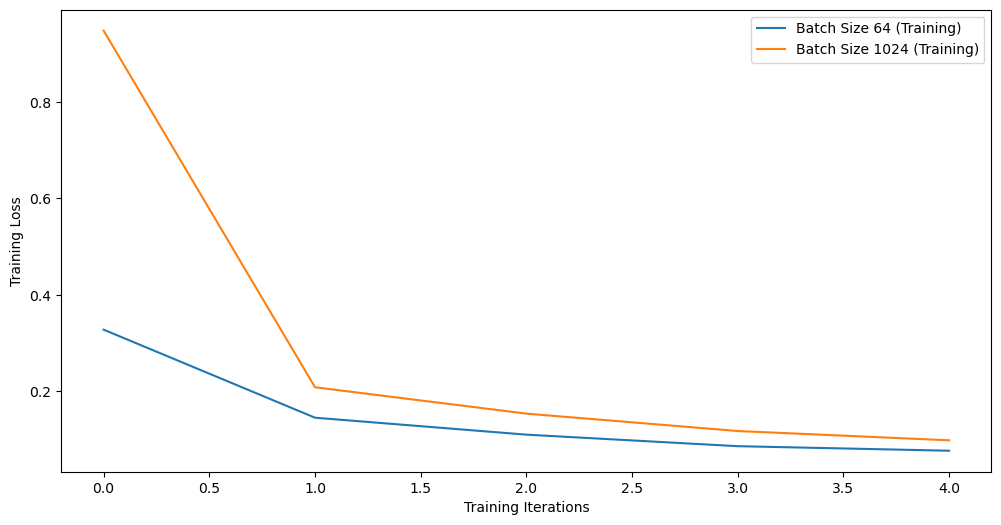

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_loss_m1, label='Batch Size 64 (Training)')
ax.plot(train_loss_m2, label='Batch Size 1024 (Training)')
ax.set_xlabel('Training Iterations')
ax.set_ylabel('Training Loss')
ax.legend()
plt.show()


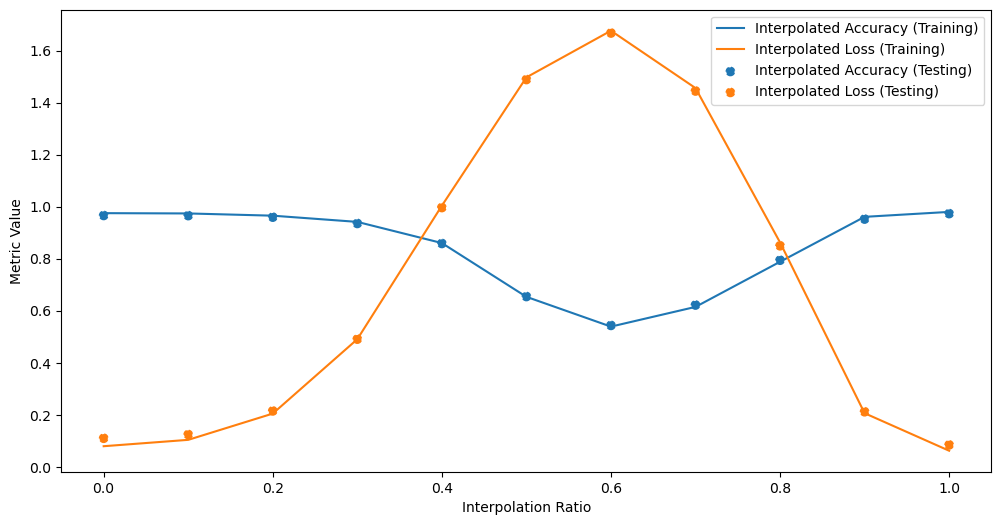

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(interpolation_ratios, interpolated_accuracies_train, label='Interpolated Accuracy (Training)')
ax.plot(interpolation_ratios, interpolated_losses_train, label='Interpolated Loss (Training)')
ax.scatter(interpolation_ratios, interpolated_accuracies_test, linestyle='--', label='Interpolated Accuracy (Testing)')
ax.scatter(interpolation_ratios, interpolated_losses_test, linestyle='--', label='Interpolated Loss (Testing)')
ax.set_xlabel('Interpolation Ratio')
ax.set_ylabel('Metric Value')
ax.legend()
plt.show()


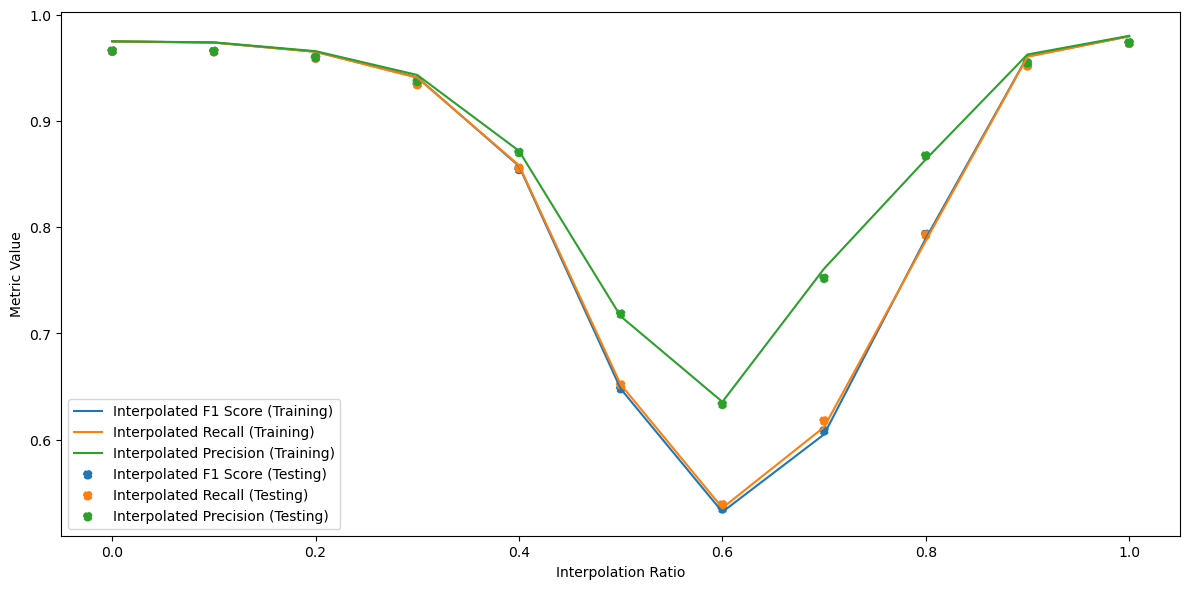

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(interpolation_ratios, interpolated_f1_scores_train, label='Interpolated F1 Score (Training)')
ax.plot(interpolation_ratios, interpolated_recalls_train, label='Interpolated Recall (Training)')
ax.plot(interpolation_ratios, interpolated_precisions_train, label='Interpolated Precision (Training)')
ax.scatter(interpolation_ratios, interpolated_f1_scores_test, linestyle='--', label='Interpolated F1 Score (Testing)')
ax.scatter(interpolation_ratios, interpolated_recalls_test, linestyle='--', label='Interpolated Recall (Testing)')
ax.scatter(interpolation_ratios, interpolated_precisions_test, linestyle='--', label='Interpolated Precision (Testing)')
ax.set_xlabel('Interpolation Ratio')
ax.set_ylabel('Metric Value')
ax.legend()
plt.tight_layout()
plt.show()
